Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from ann_visualizer.visualize import ann_viz;
import visualkeras


Reading CSV

In [2]:
gdp_data = pd.read_csv(r'..\gdp_csv.csv')
internet_speed_data = pd.read_csv(r'..\internet_speeds.csv', sep=";")
internet_access_data = pd.read_csv(r'..\internet_access.csv')
unemployment_data = pd.read_csv(r'..\unemployment.csv', on_bad_lines='skip')
military_data = pd.read_csv(r'..\military_expenditure.csv')
happy_data = pd.read_csv(r'..\world_happiness_report_2022.csv', decimal=",", sep=";")
country_codes_data = pd.read_csv(r'..\country_codes.csv', sep=";")

gdp = pd.DataFrame(gdp_data, columns=['Country Code', 'Value', 'Year'])
internet_speed = pd.DataFrame(internet_speed_data, columns=['Country','Broadband Mbps', 'Mobile Mbps', 'As of'])
internet_access = pd.DataFrame(internet_access_data, columns=['Country Code', '2020'])
unemployment = pd.DataFrame(unemployment_data, columns=['Country Code','2021'])
military = pd.DataFrame(military_data, columns=['Code', '2018'])
happy = pd.DataFrame(happy_data, columns=['Country', 'Happiness score'])
country_codes = pd.DataFrame(country_codes_data, columns=['Country', 'Alpha-3 code'])
unemployment.head(2000)

,Country Code,2021
0,ABW,NaN
1,AFE,8.111783
2,AFG,13.283000
3,AFW,6.839009
4,AGO,8.530000
...,...,...
261,XKX,NaN
262,YEM,13.574000
263,ZAF,33.558998
264,ZMB,13.026000


Renaming

In [3]:
gdp.rename(columns = {'Country Code':'CountryCode', 'Year':'YearGDP', 'Value':'GDP'}, inplace = True)
internet_speed.rename(columns = {'Country':'CountryName', 'Broadband Mbps':'BroadbandSpeed', 'Mobile Mbps':'MobileSpeed', 'As of':'YearInternetSpeed'}, inplace = True)
internet_access.rename(columns={'Country Code':'CountryCode', '2020':'InternetAccess2020'}, inplace= True)
unemployment.rename(columns= {'Country Code':'CountryCode', '2021':'Unemployment2021'}, inplace=True)
military.rename(columns= {'Code':'CountryCode', '2018':'MilitarySpending2018'}, inplace=True)
happy.rename(columns= {'Country':'CountryName', 'Happiness score':'HappinessScore2022'}, inplace=True)
country_codes.rename(columns= {'Alpha-3 code':'CountryCode', 'Country':'CountryName'}, inplace=True)

Removing unused Values

In [4]:
country_codes['CountryCode'] = country_codes['CountryCode'].replace({'"':''}, regex=True)
happy['CountryName'] = happy['CountryName'].replace({'\*':''}, regex=True)

Removing Duplicates

In [5]:
gdp.sort_values(by=['CountryCode','YearGDP'], ascending=False, inplace=True)
internet_speed.sort_values(by=['CountryName','YearInternetSpeed'], ascending=False, inplace=True)

gdp.drop_duplicates(subset=['CountryCode'], keep='first', inplace=True)
internet_speed.drop_duplicates(subset=['CountryName'], keep='first', inplace=True)

Convert Units & Round

In [6]:
gdp['GDP'] = gdp['GDP'].div(1000000000).round(2)
military['MilitarySpending2018'] = military['MilitarySpending2018'].div(1000000).round(2)

Merging

In [7]:
internet_speed = pd.merge(internet_speed, country_codes, how='left', on='CountryName')
happy = pd.merge(happy, country_codes, how='left', on='CountryName')
happy.drop('CountryName', axis=1, inplace=True)
internet_speed['CountryCode'] = internet_speed['CountryCode'].str.strip()
happy['CountryCode'] = happy['CountryCode'].str.strip()
internet_access['CountryCode'] = internet_access['CountryCode'].str.strip()
unemployment['CountryCode'] = unemployment['CountryCode'].str.strip()
military['CountryCode'] = military['CountryCode'].str.strip()
dataset = pd.merge(internet_speed, gdp, how='left', on = 'CountryCode')
dataset = pd.merge(dataset, internet_access, how='left', on='CountryCode')
dataset = pd.merge(dataset, unemployment, how='left', on='CountryCode')
dataset = pd.merge(dataset, military, how='left', on='CountryCode')
dataset = pd.merge(dataset, happy, how='left', on='CountryCode')
dataset.head(2000)

,CountryName,BroadbandSpeed,MobileSpeed,YearInternetSpeed,CountryCode,GDP,YearGDP,InternetAccess2020,Unemployment2021,MilitarySpending2018,HappinessScore2022
0,Zimbabwe,5.21,12.02,January 2022,ZWE,16.62,2016.0,29.30,5.174,420.36,2.995
1,Zambia,4.60,12.46,January 2022,ZMB,21.06,2016.0,19.80,13.026,378.03,3.760
2,Yemen,2.74,0.53,January 2022,YEM,27.32,2016.0,NaN,13.574,NaN,4.197
3,Western Sahara,10.51,NaN,January 2022,ESH,NaN,NaN,NaN,NaN,NaN,NaN
4,Vietnam,67.50,39.01,January 2022,VNM,205.28,2016.0,70.30,2.166,5500.00,5.485
...,...,...,...,...,...,...,...,...,...,...,...
175,Angola,11.97,25.43,January 2022,AGO,95.34,2016.0,36.00,8.530,1983.61,NaN
176,Andorra,92.42,NaN,January 2022,AND,2.86,2016.0,NaN,NaN,NaN,NaN
177,Algeria,9.72,11.31,January 2022,DZA,159.05,2016.0,62.90,12.704,9583.72,5.122
178,Albania,33.50,35.62,January 2022,ALB,11.86,2016.0,72.24,11.819,180.49,5.199


GDP - Broadband Speed

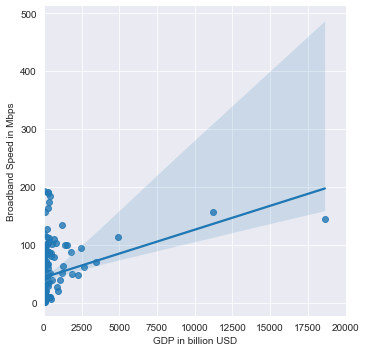

In [8]:
plotBroadBand = sns.lmplot(x="GDP", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Broadband Speed.png')
plt.show()

GDP - Mobile Speed

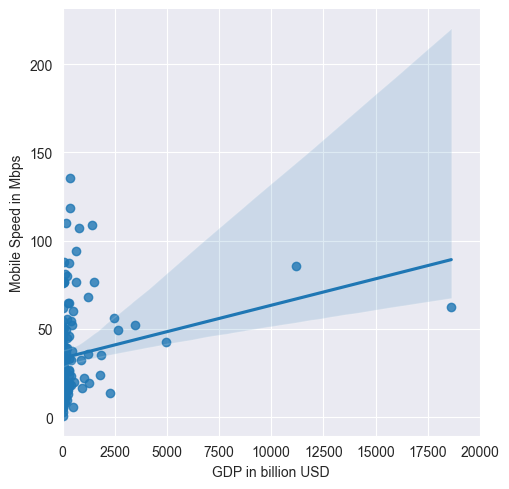

In [9]:
plotBroadBand = sns.lmplot(x="GDP", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Mobile Speed.png')
plt.show()

Internet Access - Mobile Speed

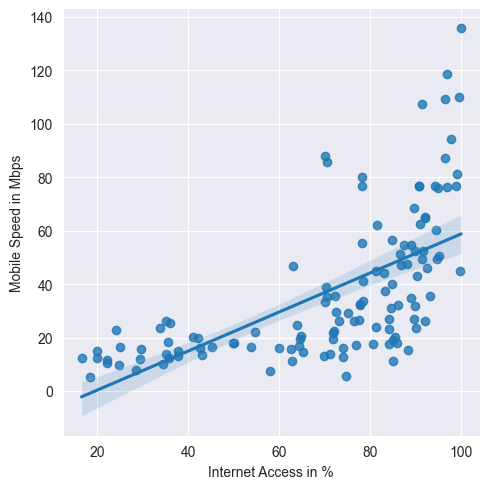

In [10]:
plotBroadBand = sns.lmplot(x="InternetAccess2020", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Mobile Speed.png')
plt.show()

Internet Access - Broadband Speed

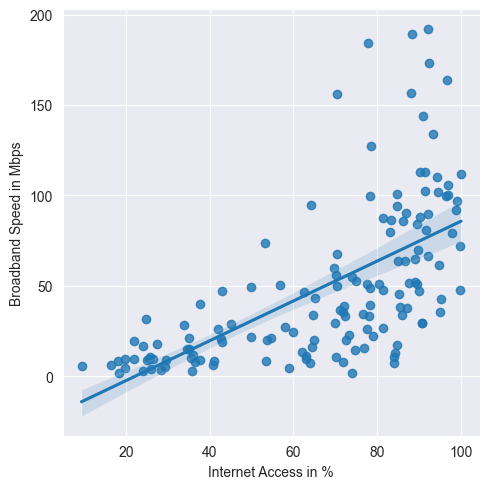

In [11]:
plotBroadBand = sns.lmplot(x="InternetAccess2020", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Broadband Speed.png')
plt.show()

Unemployment - Mobile Speed

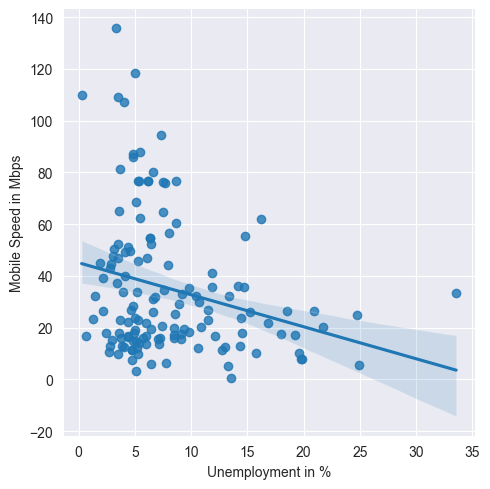

In [12]:
plotBroadBand = sns.lmplot(x="Unemployment2021", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Mobile Speed.png')
plt.show()

Unemployment - Broadband Speed

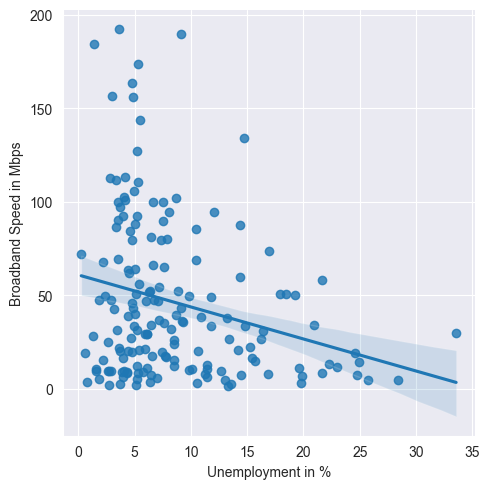

In [13]:
plotBroadBand = sns.lmplot(x="Unemployment2021", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Broadband Speed.png')
plt.show()

Military Spending - Broadband Speed

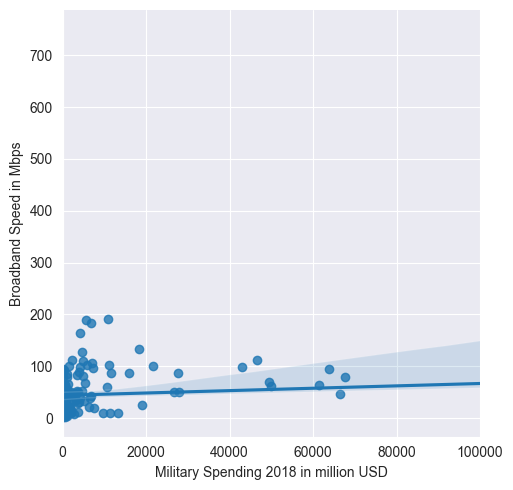

In [14]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Broadband Speed.png')
plt.show()

Military Spending - Mobile Speed

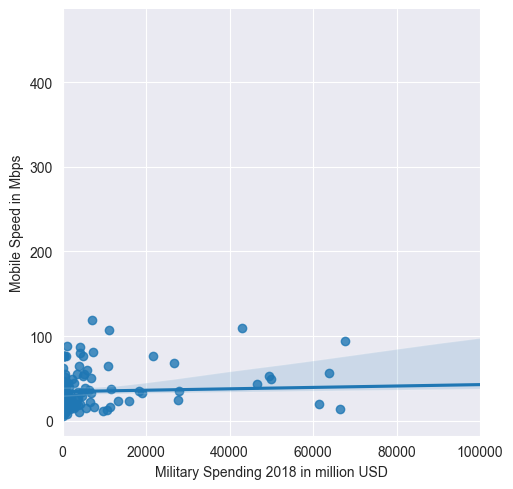

In [15]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Mobile Speed.png')
plt.show()

Happiness Score - Mobile Speed

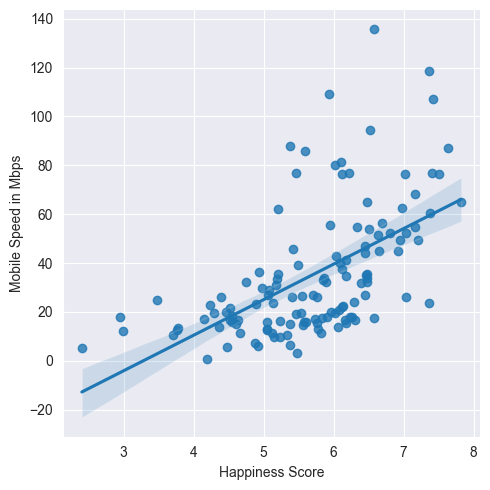

In [16]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Mobile Speed.png')
plt.show()

Happiness Score - Broadband Speed

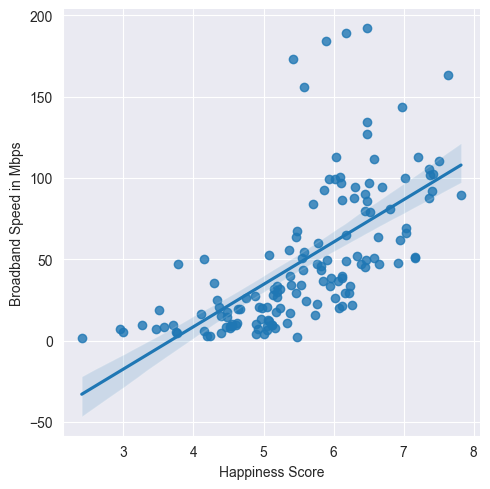

In [17]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Broadband Speed.png')
plt.show()

Boxplot GDP

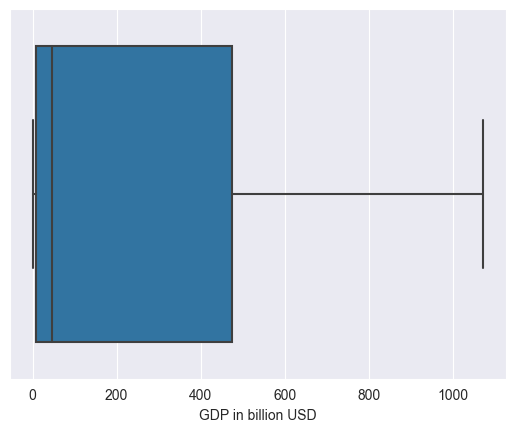

In [18]:
plotBroadBand = sns.boxplot(x=gdp['GDP'], showfliers = False)
#plotBroadBand = sns.swarmplot(x=gdp['GDP'], color="r")
plotBroadBand.set(
    xlabel='GDP in billion USD'
)
plotBroadBand.get_figure().savefig(r'..\output\GDP Boxplot.png')
plt.show()

Boxplot Mobile Speed

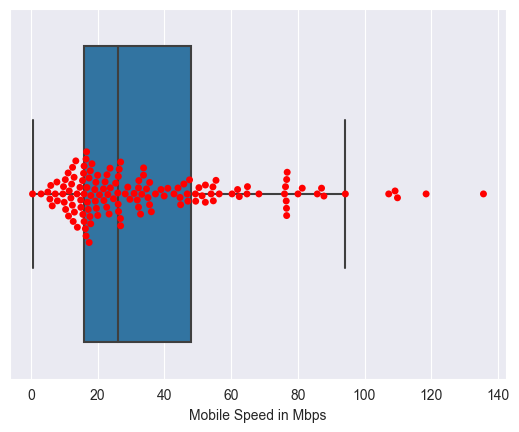

In [19]:
plotBroadBand = sns.boxplot(x=dataset['MobileSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['MobileSpeed'], color="r")
plotBroadBand.set(
    xlabel='Mobile Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Mobile Speed Boxplot.png')
plt.show()

Boxplot Broadband Speed

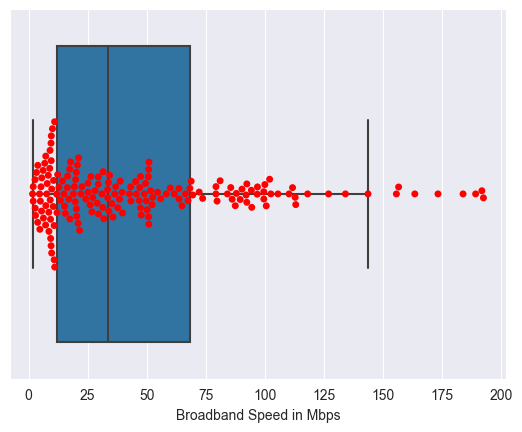

In [20]:
plotBroadBand = sns.boxplot(x=dataset['BroadbandSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['BroadbandSpeed'], color="r")
plotBroadBand.set(
    xlabel='Broadband Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Broadband Speed Boxplot.png')
plt.show()

Happiness Score Boxplot

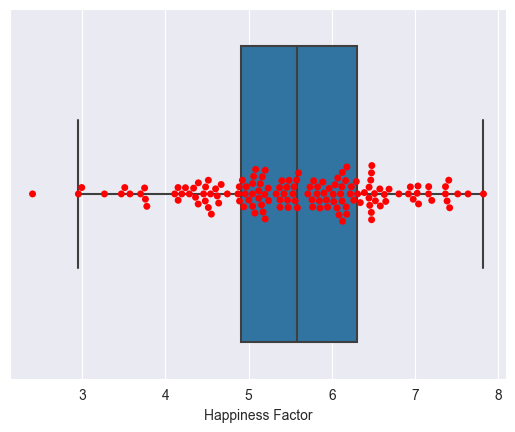

In [21]:
plotBroadBand = sns.boxplot(x=dataset['HappinessScore2022'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['HappinessScore2022'], color="r")
plotBroadBand.set(
    xlabel='Happiness Factor'
)
plotBroadBand.get_figure().savefig(r'..\output\Happiness Boxplot.png')
plt.show()

Unemployment Boxplot

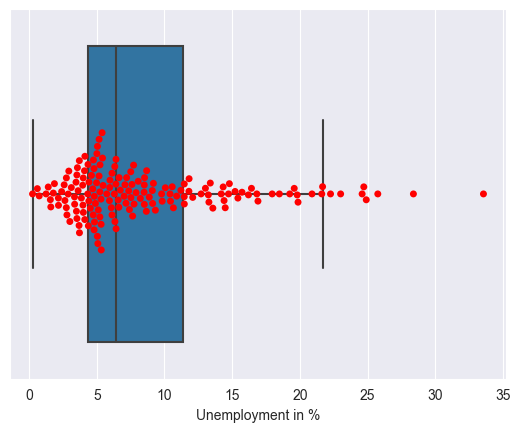

In [22]:
plotBroadBand = sns.boxplot(x=dataset['Unemployment2021'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['Unemployment2021'], color="r")
plotBroadBand.set(
    xlabel='Unemployment in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Unemployment Boxplot.png')
plt.show()

Internet Access Boxplot

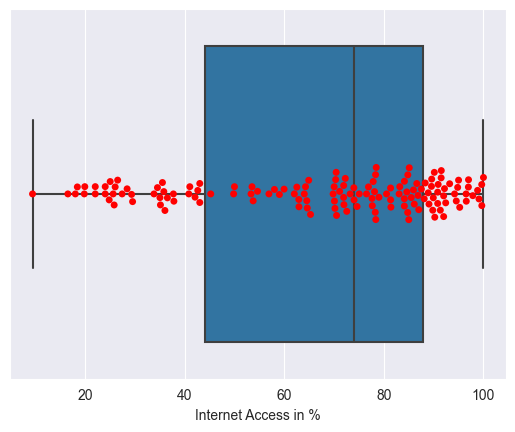

In [23]:
plotBroadBand = sns.boxplot(x=dataset['InternetAccess2020'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['InternetAccess2020'], color="r")
plotBroadBand.set(
    xlabel='Internet Access in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Internet Access Boxplot.png')
plt.show()

Military Spending Boxplot

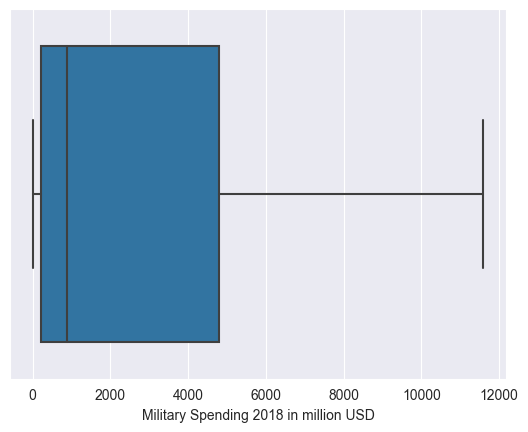

In [24]:
plotBroadBand = sns.boxplot(x=dataset['MilitarySpending2018'], showfliers= False)
#plotBroadBand = sns.swarmplot(x=dataset['MilitarySpending2018'], color="r")
plotBroadBand.set(
    xlabel='Military Spending 2018 in million USD'
)
plotBroadBand.get_figure().savefig(r'..\output\Military Spending Boxplot.png')
plt.show()

NaN Percentage

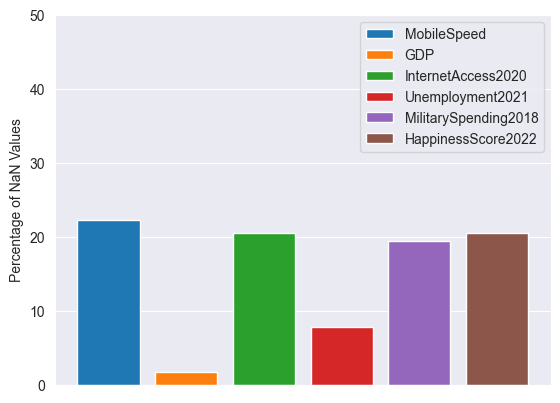

In [25]:
percent = dataset.isna().mean().round(4) * 100
f, ax = plt.subplots()
percent.drop('YearGDP', axis=0, inplace=True)

for i,item in enumerate(zip(percent.keys(),percent.values)):
    if (item[1] > 0):
        ax.bar(item[0], item[1], label = item[0])
        #ax.text(i - 0.25, item[1] + 1.5 , str(np.round(item[1],2)))

ax.set_xticklabels([]) 
ax.set_xticks([])
plt.ylim(0,50)
plt.ylabel('Percentage of NaN Values')
plt.legend()
plt.savefig(r'..\output\NaN Values.png')
plt.show()

Pair plot - Mobile Speed

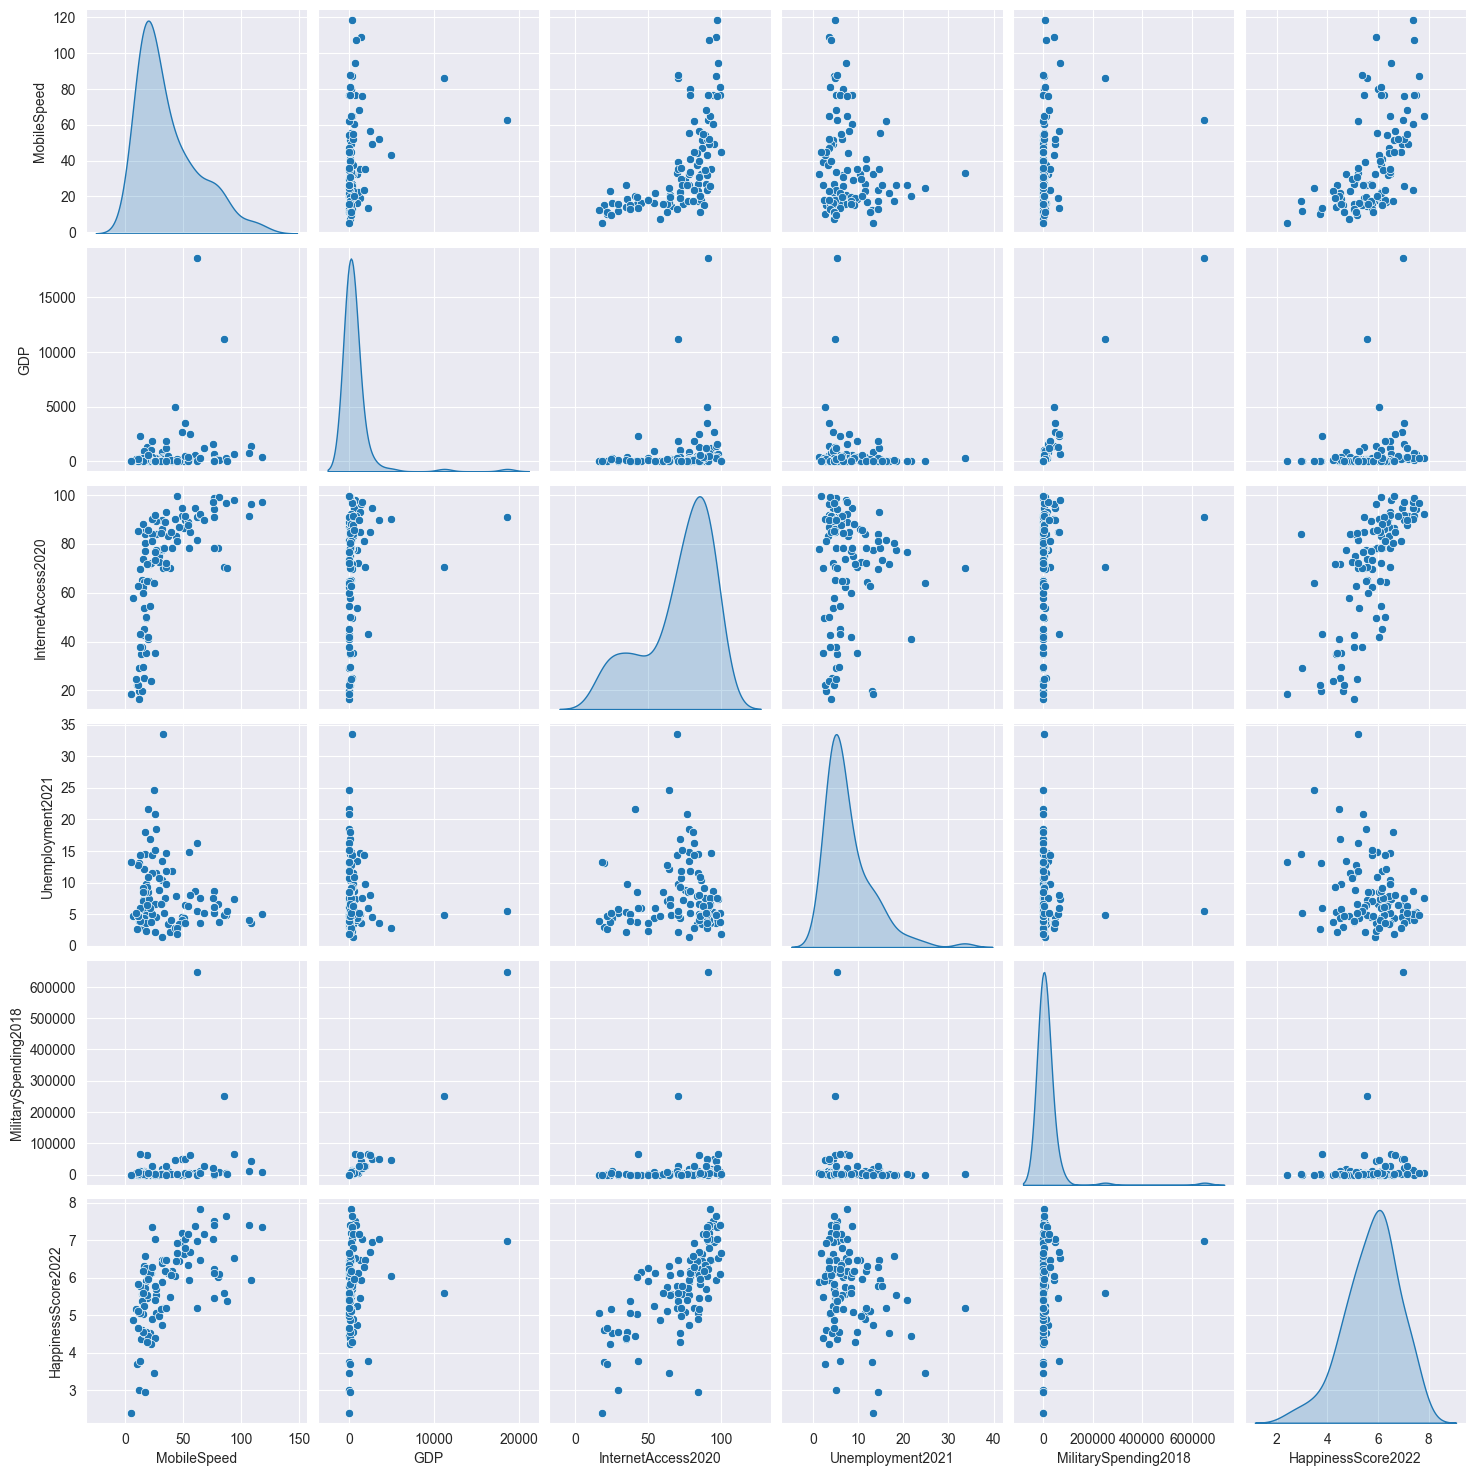

In [26]:
tmpMobile = dataset.drop('CountryCode', axis=1)
tmpMobile.drop('CountryName', axis=1, inplace=True)
tmpMobile.drop('YearGDP', axis=1, inplace=True)
tmpMobile.drop('YearInternetSpeed', axis=1, inplace=True)
tmpMobile.drop('BroadbandSpeed', axis=1, inplace=True)

tmpMobile = tmpMobile.dropna()

plot = sns.pairplot(tmpMobile[['MobileSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Mobile Speed - Pair plot.png')
plt.show()

Neural Network - MobileSpeed

In [31]:
network = Sequential()
network.add(Dense(units=4,
                  activation='relu',
                  kernel_initializer='uniform',
                  input_dim=6))
network.add(Dense(units=3,
                  activation='relu',
                  kernel_initializer='uniform'))
network.add(Dense(units=2,
                  activation='relu',
                  kernel_initializer='uniform'))
network.add(Dense(units=1,
                  activation='sigmoid',
                  kernel_initializer='uniform'))
network.

ann_viz(network, True, '..\output\Mobile Speed - Neural Network.png', 'Neural Network MobileSpeed')

Pair plot - Broadband Speed

In [ ]:
tmpBroadband = dataset.drop('CountryCode', axis=1)
tmpBroadband.drop('CountryName', axis=1, inplace=True)
tmpBroadband.drop('YearGDP', axis=1, inplace=True)
tmpBroadband.drop('YearInternetSpeed', axis=1, inplace=True)
tmpBroadband.drop('MobileSpeed', axis=1, inplace=True)

tmpBroadband = tmpBroadband.dropna()

plot = sns.pairplot(tmpBroadband[['BroadbandSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Broadband Speed - Pair plot')
plt.show()

In [ ]:
percent = dataset.isna().mean().round(4) * 100
f, ax = plt.subplots()
percent.drop('YearGDP', axis=0, inplace=True)

for i,item in enumerate(zip(percent.keys(),percent.values)):
    if (item[1] > 0):
        ax.bar(item[0], item[1], label = item[0])
        #ax.text(i - 0.25, item[1] + 1.5 , str(np.round(item[1],2)))

ax.set_xticklabels([]) 
ax.set_xticks([])
plt.ylim(0,50)
plt.ylabel('Percentage of NaN Values')
plt.legend()
plt.savefig(r'..\output\NaN Values.png')
plt.show()

Pair plot - Mobile Speed

In [ ]:
tmpMobile = dataset.drop('CountryCode', axis=1)
tmpMobile.drop('CountryName', axis=1, inplace=True)
tmpMobile.drop('YearGDP', axis=1, inplace=True)
tmpMobile.drop('YearInternetSpeed', axis=1, inplace=True)
tmpMobile.drop('BroadbandSpeed', axis=1, inplace=True)

tmpMobile = tmpMobile.dropna()

plot = sns.pairplot(tmpMobile[['MobileSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Mobile Speed - Pair plot.png')
plt.show()

Neural Network - MobileSpeed

Pair plot - Broadband Speed

In [ ]:
network = Sequential()
network.add(Dense(units=4,
                  activation='relu',
                  kernel_initializer='uniform',
                  input_dim=6))
network.add(Dense(units=4,
                  activation='relu',
                  kernel_initializer='uniform'))
network.add(Dense(units=3,
                  activation='relu',
                  kernel_initializer='uniform'))
network.add(Dense(units=3,
                  activation='relu',
                  kernel_initializer='uniform'))
network.add(Dense(units=2,
                  activation='relu',
                  kernel_initializer='uniform'))
network.add(Dense(units=2,
                  activation='relu',
                  kernel_initializer='uniform'))
network.add(Dense(units=1,
                  activation='sigmoid',
                  kernel_initializer='uniform'))


ann_viz(network, True, '..\output\Mobile Speed - Neural Network.png', 'Neural Network Internet Speed')

In [ ]:
tmpBroadband = dataset.drop('CountryCode', axis=1)
tmpBroadband.drop('CountryName', axis=1, inplace=True)
tmpBroadband.drop('YearGDP', axis=1, inplace=True)
tmpBroadband.drop('YearInternetSpeed', axis=1, inplace=True)
tmpBroadband.drop('MobileSpeed', axis=1, inplace=True)

tmpBroadband = tmpBroadband.dropna()

plot = sns.pairplot(tmpBroadband[['BroadbandSpeed', 'GDP', 'InternetAccess2020', 'Unemployment2021', 'MilitarySpending2018', 'HappinessScore2022']], diag_kind='kde')
plot.savefig(r'..\output\Broadband Speed - Pair plot.png')
plt.show()